In [99]:
import csv
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
from datetime import datetime, date
from dateutil import parser
import urllib3
import statistics
import warnings
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from collections import Counter

In [44]:
datashades_raw_list = "shades.csv"

outside_list = ['http://data.ctdata.org/',
                'https://data.ci.newark.nj.us/',
                'https://open.jacksonms.gov/',
                'https://data.ca.gov/',
                'https://datagate.snap4city.org/'
                ]

def write_output_file(all_urls_final, filename):
    fieldnames = []
    for item in all_urls_final:
        if len(item.keys()) > len(fieldnames):
            fieldnames = item.keys()

    with open(filename, "w", encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        writer.writeheader()
        for item in all_urls_final:
            writer.writerow(item)

In [45]:
def datashades_clean_up(datashades_list):
    urls = []
    with open(datashades_list, newline="", encoding="utf-8") as f:
        reader = csv.reader(f)
        for row in reader:
            row_strip = row[0].strip()
            if row_strip[:5] == "href=":
                to_add = row_strip[37:-19]
                urls.append(to_add.split('%2F">')[0])
            else:
                pass

    clean_urls = []
    for item in urls:
        item = re.sub("%3A", ":", item)
        item = re.sub("%2F", "/", item)
        item = re.sub("%26", "%", item)
        item = re.sub("%3D", "=", item)
        item = re.sub("%3F", "?", item)
        item = re.sub("%23", "#", item)
        clean_urls.append(item)

    return clean_urls

def dataportals_clean_up():
    portals_df = pd.read_csv("https://raw.githubusercontent.com/okfn/dataportals.org/master/data/portals.csv")
    portals_list = list(portals_df.url)
    return portals_list

def url_setup(source, clean_urls):
    root_url_set = set()
    list_of_url_dicts_2 = []
    for item in clean_urls:
        root_url = item.split("/")[2]
        if root_url in root_url_set:
            pass
        else:
            root_url_set.add(root_url)
            url_dict = {}
            url_dict["source"] = source
            url_dict["source_url"] = item
            url_dict["root_url"] = root_url
            url_dict["base_url"] = item.split(root_url)[0]+root_url
            list_of_url_dicts_2.append(url_dict)
    return list_of_url_dicts_2

clean_shades_urls = datashades_clean_up(datashades_raw_list)
clean_portals_urls = dataportals_clean_up()
shades = url_setup("datashades.info", clean_shades_urls)
portals = url_setup("dataportals.org", clean_portals_urls)
wprdc = url_setup("WPRDC", outside_list)

In [46]:
def duplicate_removal_processing(list_of_lists_to_deduplicate):
    unique_urls = set()
    output_list = []
    for item in list_of_lists_to_deduplicate:
        for items in item:
            if items['root_url'] in unique_urls:
                pass
            else:
                output_list.append(items)
                unique_urls.add(items['root_url'])
    return output_list

list_of_lists = [shades, portals, wprdc]
combined_and_deduplicated = duplicate_removal_processing(list_of_lists)

In [47]:
len(combined_and_deduplicated)

1031

In [48]:
def checking_for_response(passed_list):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    full_error_list = []
    count = 0
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    for item in passed_list:
        count+=1
        try:
            print(f'Now checking url #{count}: {item["source_url"]}')
            response = requests.get(item["source_url"], verify=False, headers=headers, timeout=120)
            status = response.status_code
            soup = BeautifulSoup(response.text, features="html.parser")
            name = str(soup.title.string)
            meta_tags = soup.find_all("meta")
            if len(meta_tags)>0:
                for element in meta_tags:
                    if element.get("name") == "generator":
                        generator = element.get("content")
                    else:
                        generator = ""
            else:
                generator = ""
        except AttributeError:
            name = "AttributeError"
        except requests.exceptions.SSLError as ssl_error:
            name = "SSL Error"
            generator = ""
        except requests.exceptions.ConnectionError as connect_error:
            name = "Connection Error"
            generator = ""
        except requests.exceptions.TooManyRedirects:
            name = "Too Many Redirects Error"
            generator = ""
        except requests.exceptions.Timeout:
            name = "Timeout"
            generator = ""
        except Exception as e:
                try:
                    name = e.response.text
                except:
                    name = "Error"
        item["name"] = name
        item["generator"] = generator
        item["status_code"] = status
    return passed_list

status_response = checking_for_response(combined_and_deduplicated)

Now checking url #1: https://data.cambridgeshireinsight.org.uk/search/field_topics/type/dataset?sort_by=changed
Now checking url #2: https://africaopendata.org
Now checking url #3: https://govtech.in.th
Now checking url #4: https://opingogn.is
Now checking url #5: http://data.openpolice.ru
Now checking url #6: https://datos.agroindustria.gob.ar
Now checking url #7: http://dados.ufrn.br
Now checking url #8: http://data.odw.tw
Now checking url #9: https://data.gov.ie
Now checking url #10: https://geocatalogus.nl
Now checking url #11: http://dados.mda.gov.br
Now checking url #12: http://data.mariupolrada.gov.ua
Now checking url #13: http://dados.ufop.br
Now checking url #14: https://data.barrowbc.gov.uk
Now checking url #15: https://opendata.ugr.es
Now checking url #16: https://dados.uffs.edu.br
Now checking url #17: http://portal.igg.ac.mn
Now checking url #18: https://data.ed.gov
Now checking url #19: http://opendata.gov.mn
Now checking url #20: https://daten.rlp.de
Now checking url #21

Now checking url #162: http://opendata.semarangkota.go.id
Now checking url #163: https://data.sba.gov
Now checking url #164: http://dados.ufes.br
Now checking url #165: https://data-test.toll.no
Now checking url #166: https://ckanviz.swige.unhcr.org
Now checking url #167: https://datos.gob.sv
Now checking url #168: http://dados.gov.br
Now checking url #169: https://dadosabertos.prefeitura.poa.br
Now checking url #170: https://opendata.mzcr.cz
Now checking url #171: http://b2find.eudat.eu
Now checking url #172: https://opendata.portdebarcelona.cat
Now checking url #173: http://dados.mg.gov.br
Now checking url #174: http://datos.techo.org
Now checking url #175: https://data.cityofboston.gov
Now checking url #176: http://opendata.ayto-caceres.es
Now checking url #177: http://datos.misiones.gov.ar
Now checking url #178: https://dados.ifsp.edu.br
Now checking url #179: https://www.eia.gov/environment/data.php/data
Now checking url #180: https://dadosabertos.senado.gov.br/data
Now checking u

Now checking url #321: https://ouvert.canada.ca/ckan
Now checking url #322: https://ckan.otevrenamesta.cz
Now checking url #323: https://data.overheid.nl/data
Now checking url #324: https://catalogue.cioos.ca
Now checking url #325: https://catalogue.ogsl.ca
Now checking url #326: http://rotterdamopendata.nl
Now checking url #327: http://dataportal.saeri.org//
Now checking url #328: https://data.london.gov.uk/dataset
Now checking url #329: https://openbudgetsindia.org
Now checking url #330: http://publications.aberdeenshire.gov.uk
Now checking url #331: http://dados.ufsm.br
Now checking url #332: https://dados.ufrgs.br
Now checking url #333: http://dados.al.gov.br
Now checking url #334: https://datastore.landcareresearch.co.nz
Now checking url #335: https://dados.ufca.edu.br
Now checking url #336: https://dados.ifro.edu.br
Now checking url #337: http://data.bayanat.ae
Now checking url #338: https://library.atticawetlands.eu
Now checking url #339: https://data.city.yokohama.lg.jp
Now che

Now checking url #477: https://dados.ufrr.br
Now checking url #478: https://data.openstate.eu
Now checking url #479: https://phoenixopendata.com
Now checking url #480: http://opendata.lisra.jp
Now checking url #481: https://bernco.civicdashboards.com
Now checking url #482: http://datamx.io
Now checking url #483: https://transparenz.karlsruhe.de
Now checking url #484: http://data.gov.ro
Now checking url #485: https://transportdata.be
Now checking url #486: https://opendata.meteo.tn
Now checking url #487: https://dataportal.smartme.io
Now checking url #488: https://data.aberdeencity.gov.uk
Now checking url #489: http://catalogo.governoaberto.sp.gov.br
Now checking url #490: https://dataportal.cps.chula.ac.th
Now checking url #491: https://www.odaa.dk/ckan
Now checking url #492: http://data.ottawa.ca
Now checking url #493: https://data.pontianakkota.go.id
Now checking url #494: https://datenportal.pado-projekt.de
Now checking url #495: https://www.donostia.eus/datosabiertos
Now checking u

Now checking url #627: https://www.data.go.kr
Now checking url #628: http://www.data.gov/catalog
Now checking url #629: http://data.mos.ru
Now checking url #630: http://www.gov.hk/en/theme/psi
Now checking url #631: http://data.seattle.gov/
Now checking url #632: http://www.datosabiertos.jcyl.es/
Now checking url #633: http://data.gv.at/
Now checking url #634: http://data.linz.gv.at/
Now checking url #635: http://opendata.admin.ch/
Now checking url #636: http://data.civicinfo.ca/
Now checking url #637: https://data.colorado.gov/
Now checking url #638: http://abertos.xunta.es/
Now checking url #639: http://data.go.jp
Now checking url #640: http://data.go.th/
Now checking url #641: http://www.data.gouv.fr/
Now checking url #642: http://data.gov.ph
Now checking url #643: http://data.gov.tw/
Now checking url #644: https://data.hartford.gov/
Now checking url #645: http://data.lincoln.ac.uk/
Now checking url #646: http://datameti.go.jp/
Now checking url #647: http://data.norge.no/
Now checki

Now checking url #779: http://data.gov.ma/
Now checking url #780: http://morocco.opendataforafrica.org/
Now checking url #781: http://data.mosman.nsw.gov.au/
Now checking url #782: http://mozambique.opendataforafrica.org/
Now checking url #783: http://www.mulhouse.fr/fr/les-donnees/
Now checking url #784: http://datos.gob.mx/
Now checking url #785: http://namibia.opendataforafrica.org/
Now checking url #786: http://data.nanaimo.ca/
Now checking url #787: http://data.nantes.fr
Now checking url #788: http://dati.istat.it/
Now checking url #789: http://www.avoindata.fi
Now checking url #790: http://www.naturalearthdata.com/
Now checking url #791: http://opendata.navarra.es
Now checking url #792: http://www.ncopenbook.gov/NCOpenBook/
Now checking url #793: http://opendatanederland.org
Now checking url #794: http://www.neii.gov.au
Now checking url #795: https://data-nevcounty.opendata.arcgis.com/
Now checking url #796: http://data.nola.gov/
Now checking url #797: http://www.niagararegion.ca

Now checking url #918: http://southsudan.opendataforafrica.org/
Now checking url #919: http://datos.gob.es
Now checking url #920: https://data.sunshinecoast.qld.gov.au/
Now checking url #921: http://www.statcentral.ie/
Now checking url #922: http://www.nebraska.gov/data/
Now checking url #923: http://data.wa.gov/
Now checking url #924: http://www.strathcona.ca/local-government/strathcona-county-elections/election-2013-open-data/
Now checking url #925: http://data.suomi.fi
Now checking url #926: http://www.surrey.ca/city-services/658.aspx
Now checking url #927: http://www.sutton.gov.uk
Now checking url #928: http://data.taichung.gov.tw/
Now checking url #929: http://tampere.fi/avoindata
Now checking url #930: http://tanzania.opendataforafrica.org/
Now checking url #931: http://www.texas.gov/en/Connect/Pages/open-data.aspx
Now checking url #932: http://www.texastransparency.org/opendata/index.php
Now checking url #933: http://data.pm.go.th/
Now checking url #934: http://www.thunderbay.ca

In [57]:
stats_dict = {"datashades.info": {"original_url_list_length": len(shades), "count":0, "200":0}, "dataportals.org": {"original_url_list_length": len(portals), "count":0, "200":0}, "WPRDC": {"original_url_list_length": len(wprdc), "count":0, "200":0}}
for item in status_response:
    for items in stats_dict:
        if item['source'] == items:
            stats_dict[items]['count']+=1
            if item['status_code'] == 200:
                stats_dict[items]['200']+=1

for item in stats_dict:
    print(f'{item}: {stats_dict[item]}')

datashades.info: {'original_url_list_length': 516, 'count': 516, '200': 478}
dataportals.org: {'original_url_list_length': 592, 'count': 510, '200': 420}
WPRDC: {'original_url_list_length': 5, 'count': 5, '200': 5}


In [55]:
def ckan_status_show(passed_list):
    full_error_list = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    x=0
    for item in passed_list:
        x+=1
        print(f'Now performing a status_show api call on site #{x}: {item["root_url"]}')
        try:
            response = requests.get(f'{item["source_url"]}/api/3/action/status_show', verify=False, headers=headers, timeout=120)
            content = json.loads(response.content)
            item["api_base_url"] = content["result"]["site_url"]
            item["site_title"] = content["result"]["site_title"]
            item["version"] = content["result"]["ckan_version"]
            item["locale"] = content["result"]["locale_default"]
            item["extensions"] = content["result"]["extensions"]
            item["source_or_base"] = "source"
        except Exception as e:
            try:
                response = requests.get(f'{item["base_url"]}/api/3/action/status_show', verify=False, headers=headers, timeout=120)
                content = json.loads(response.content)
                item["api_base_url"] = content["result"]["site_url"]
                item["site_title"] = content["result"]["site_title"]
                item["version"] = content["result"]["ckan_version"]
                item["locale"] = content["result"]["locale_default"]
                item["extensions"] = content["result"]["extensions"]
                item["source_or_base"] = "base"
            except Exception as e:
                error_list = [item["source_url"], (e.args)]
                full_error_list.append(error_list)
                pass
    return passed_list

status_show = ckan_status_show(status_response)

Now performing a status_show api call on site #1: data.cambridgeshireinsight.org.uk
Now performing a status_show api call on site #2: africaopendata.org
Now performing a status_show api call on site #3: govtech.in.th
Now performing a status_show api call on site #4: opingogn.is
Now performing a status_show api call on site #5: data.openpolice.ru
Now performing a status_show api call on site #6: datos.agroindustria.gob.ar
Now performing a status_show api call on site #7: dados.ufrn.br
Now performing a status_show api call on site #8: data.odw.tw
Now performing a status_show api call on site #9: data.gov.ie
Now performing a status_show api call on site #10: geocatalogus.nl
Now performing a status_show api call on site #11: dados.mda.gov.br
Now performing a status_show api call on site #12: data.mariupolrada.gov.ua
Now performing a status_show api call on site #13: dados.ufop.br
Now performing a status_show api call on site #14: data.barrowbc.gov.uk
Now performing a status_show api call o

Now performing a status_show api call on site #118: dadosabertos.bndes.gov.br
Now performing a status_show api call on site #119: pacificdata.org
Now performing a status_show api call on site #120: drdsi.jrc.ec.europa.eu
Now performing a status_show api call on site #121: data.surrey.ca
Now performing a status_show api call on site #122: dados.agricultura.gov.br
Now performing a status_show api call on site #123: scoda.co.za
Now performing a status_show api call on site #124: www.data.gov.my
Now performing a status_show api call on site #125: data.ehealthireland.ie
Now performing a status_show api call on site #126: ckan.fiware-testbed.jp
Now performing a status_show api call on site #127: opendata.ozwillo.com
Now performing a status_show api call on site #128: datenregister.berlin.de
Now performing a status_show api call on site #129: staging.justicehub.in
Now performing a status_show api call on site #130: donneesquebec.ca
Now performing a status_show api call on site #131: opendata.

Now performing a status_show api call on site #233: transparencia.enargas.gov.ar
Now performing a status_show api call on site #234: api.foodsecurityportal.org
Now performing a status_show api call on site #235: ckan.pref.shizuoka.jp
Now performing a status_show api call on site #236: radius.amplusdata.io
Now performing a status_show api call on site #237: datosretc.mma.gob.cl
Now performing a status_show api call on site #238: tpbs.igenco.co.th
Now performing a status_show api call on site #239: data.gov.ua
Now performing a status_show api call on site #240: data.vbgov.com
Now performing a status_show api call on site #241: dati.mit.gov.it
Now performing a status_show api call on site #242: ckan.cabi.org
Now performing a status_show api call on site #243: www.donneesquebec.ca
Now performing a status_show api call on site #244: opendatalecce.apposta.biz
Now performing a status_show api call on site #245: podatki.gov.si
Now performing a status_show api call on site #246: data.gov.sk
Now

Now performing a status_show api call on site #347: portal.merit.mn
Now performing a status_show api call on site #348: portal.openbelgium.be
Now performing a status_show api call on site #349: datos.salud.gob.ar
Now performing a status_show api call on site #350: data.wprdc.org
Now performing a status_show api call on site #351: data.whiterockcity.ca
Now performing a status_show api call on site #352: data.tainan.gov.tw
Now performing a status_show api call on site #353: hri.fi
Now performing a status_show api call on site #354: opendata.aachen.de
Now performing a status_show api call on site #355: scidm.nchc.org.tw
Now performing a status_show api call on site #356: opendata.materaevents.it
Now performing a status_show api call on site #357: data.salzburgerland.com
Now performing a status_show api call on site #358: ckan.ev.openindustry.in
Now performing a status_show api call on site #359: www.transparencia.mg.gov.br
Now performing a status_show api call on site #360: data.opendata.

Now performing a status_show api call on site #459: data.cdc.gov.tw
Now performing a status_show api call on site #460: data.corkcity.ie
Now performing a status_show api call on site #461: dadosabertos.ufma.br
Now performing a status_show api call on site #462: datos.arsat.com.ar
Now performing a status_show api call on site #463: data.mempawahkab.go.id
Now performing a status_show api call on site #464: data.edincubator.eu
Now performing a status_show api call on site #465: data.sanjoseca.gov
Now performing a status_show api call on site #466: data.staging.sba.gov
Now performing a status_show api call on site #467: data.investigatemidwest.org
Now performing a status_show api call on site #468: datosabiertos.mineduc.gob.gt
Now performing a status_show api call on site #469: data.gov.sa
Now performing a status_show api call on site #470: daten.buergernetz.bz.it
Now performing a status_show api call on site #471: data.env.go.jp
Now performing a status_show api call on site #472: data.nrr

Now performing a status_show api call on site #573: data.chattlibrary.org
Now performing a status_show api call on site #574: data.cityofchicago.org
Now performing a status_show api call on site #575: datos.bcn.cl
Now performing a status_show api call on site #576: www.consejotransparencia.cl
Now performing a status_show api call on site #577: www.chilliwack.com
Now performing a status_show api call on site #578: govinfo.nlc.gov.cn
Now performing a status_show api call on site #579: opendurham.nc.gov
Now performing a status_show api call on site #580: data.honolulu.gov
Now performing a status_show api call on site #581: data-avl.opendata.arcgis.com
Now performing a status_show api call on site #582: data.austintexas.gov
Now performing a status_show api call on site #583: data.brla.gov
Now performing a status_show api call on site #584: bouldercolorado.gov
Now performing a status_show api call on site #585: data.culvercity.org
Now performing a status_show api call on site #586: data.det

Now performing a status_show api call on site #690: open-data.europa.eu
Now performing a status_show api call on site #691: www.europeandataportal.eu
Now performing a status_show api call on site #692: opendata.euskadi.net
Now performing a status_show api call on site #693: ckan.net
Now performing a status_show api call on site #694: www.extremadurareutiliza.es
Now performing a status_show api call on site #695: datanest.fair-play.sk
Now performing a status_show api call on site #696: data.fingal.ie
Now performing a status_show api call on site #697: beta.avoindata.fi
Now performing a status_show api call on site #698: www.fredericton.ca
Now performing a status_show api call on site #699: data.gwd.go.kr
Now performing a status_show api call on site #700: www.gatineau.ca
Now performing a status_show api call on site #701: dadesobertes.gencat.cat
Now performing a status_show api call on site #702: data.gent.be
Now performing a status_show api call on site #703: www.geo.be
Now performing 

Now performing a status_show api call on site #805: www.rdno.ca
Now performing a status_show api call on site #806: www.opendatanottingham.org.uk
Now performing a status_show api call on site #807: www.nysenate.gov
Now performing a status_show api call on site #808: nycopendata.socrata.com
Now performing a status_show api call on site #809: oakville.ca
Now performing a status_show api call on site #810: opendata.odiqueensland.org.au
Now performing a status_show api call on site #811: www.offenes-jena.de
Now performing a status_show api call on site #812: www.mo.gov
Now performing a status_show api call on site #813: www.floridahasarighttoknow.com
Now performing a status_show api call on site #814: www.rdos.bc.ca
Now performing a status_show api call on site #815: www.data.gov.om
Now performing a status_show api call on site #816: www.ost.pt
Now performing a status_show api call on site #817: www.ontario.ca
Now performing a status_show api call on site #818: www.opendatahub.it
Now perfo

Now performing a status_show api call on site #920: data.sunshinecoast.qld.gov.au
Now performing a status_show api call on site #921: www.statcentral.ie
Now performing a status_show api call on site #922: www.nebraska.gov
Now performing a status_show api call on site #923: data.wa.gov
Now performing a status_show api call on site #924: www.strathcona.ca
Now performing a status_show api call on site #925: data.suomi.fi
Now performing a status_show api call on site #926: www.surrey.ca
Now performing a status_show api call on site #927: www.sutton.gov.uk
Now performing a status_show api call on site #928: data.taichung.gov.tw
Now performing a status_show api call on site #929: tampere.fi
Now performing a status_show api call on site #930: tanzania.opendataforafrica.org
Now performing a status_show api call on site #931: www.texas.gov
Now performing a status_show api call on site #932: www.texastransparency.org
Now performing a status_show api call on site #933: data.pm.go.th
Now performin

In [58]:
def ckan_all_other_functions(passed_list):
    full_error_list_packages = []
    full_error_list_orgs = []
    full_error_list_tags = []
    full_error_list_dates = []
    full_error_list_new_dates = []
    x=0
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    api_calls = ['package_list', 'tag_list', 'organization_list']
    def api_check(dict_to_check, url_category, api_call):
        url = f'{dict_to_check[url_category]}/api/3/action/{api_call}'
        response = requests.get(url, verify=False, headers=headers, timeout=120)
        content = json.loads(response.content)
        dict_to_check[f"{api_call}_count"] = len(content["result"])
        dict_to_check[f"{api_call}_source_base_or_apibase"] = url_category
        return dict_to_check

    def date_check(dict_to_check, url_category, current_best_metadata_date):
        url = f'{dict_to_check[url_category]}/api/3/action/current_package_list_with_resources?limit=2000000'
        response = requests.get(url, verify=False, headers=headers, timeout=120)
        content = json.loads(response.content)
        for items in content["result"]:
            metadata_creation_date = items["metadata_created"]
            m_c_d = parser.parse(metadata_creation_date)
            if m_c_d < current_best_metadata_date:
                current_best_metadata_date = m_c_d
            else:
                pass
        item["oldest_metadata_created_date"] = current_best_metadata_date
        most_recent_update_date = content["result"][0]["metadata_modified"]
        item["most_recent_update_date"] = parser.parse(most_recent_update_date)
        item["dates_source_base_or_apibase"] = url_category
        return dict_to_check

    for item in passed_list:
        x+=1
        print(f'Now performing additional API calls on site #{x}: {item["root_url"]}')
        current_best_metadata_date = datetime.now()
        for call in api_calls:
            try:
                api_check(item, "source_url", call)
            except Exception as e:
                try:
                    api_check(item, "base_url", call)
                except Exception as e:
                    try:
                        api_check(item, "api_base_url", call)
                    except Exception as e:
                        error_list = [item["source_url"], (e.args)]
                        full_error_list_packages.append(error_list)
                        pass
        try:
            date_check(item, "source_url", current_best_metadata_date)
        except Exception as e:
            try:
                date_check(item, "base_url", current_best_metadata_date)
            except Exception as e:
                try:
                    date_check(item, "api_base_url", current_best_metadata_date)
                except Exception as e:
                    error_list = [item["source_url"], (e.args)]
                    full_error_list_dates.append(error_list)
    return passed_list

all_requests_made = ckan_all_other_functions(status_show)

Now performing additional API calls on site #1: data.cambridgeshireinsight.org.uk
Now performing additional API calls on site #2: africaopendata.org
Now performing additional API calls on site #3: govtech.in.th
Now performing additional API calls on site #4: opingogn.is
Now performing additional API calls on site #5: data.openpolice.ru
Now performing additional API calls on site #6: datos.agroindustria.gob.ar
Now performing additional API calls on site #7: dados.ufrn.br
Now performing additional API calls on site #8: data.odw.tw
Now performing additional API calls on site #9: data.gov.ie
Now performing additional API calls on site #10: geocatalogus.nl
Now performing additional API calls on site #11: dados.mda.gov.br
Now performing additional API calls on site #12: data.mariupolrada.gov.ua
Now performing additional API calls on site #13: dados.ufop.br
Now performing additional API calls on site #14: data.barrowbc.gov.uk
Now performing additional API calls on site #15: opendata.ugr.es
No

Now performing additional API calls on site #121: data.surrey.ca
Now performing additional API calls on site #122: dados.agricultura.gov.br
Now performing additional API calls on site #123: scoda.co.za
Now performing additional API calls on site #124: www.data.gov.my
Now performing additional API calls on site #125: data.ehealthireland.ie
Now performing additional API calls on site #126: ckan.fiware-testbed.jp
Now performing additional API calls on site #127: opendata.ozwillo.com
Now performing additional API calls on site #128: datenregister.berlin.de
Now performing additional API calls on site #129: staging.justicehub.in
Now performing additional API calls on site #130: donneesquebec.ca
Now performing additional API calls on site #131: opendata.comune.bari.it
Now performing additional API calls on site #132: dati.toscana.it
Now performing additional API calls on site #133: www.data.gv.at
Now performing additional API calls on site #134: opendata.imet.gr
Now performing additional API 

Now performing additional API calls on site #240: data.vbgov.com
Now performing additional API calls on site #241: dati.mit.gov.it
Now performing additional API calls on site #242: ckan.cabi.org
Now performing additional API calls on site #243: www.donneesquebec.ca
Now performing additional API calls on site #244: opendatalecce.apposta.biz
Now performing additional API calls on site #245: podatki.gov.si
Now performing additional API calls on site #246: data.gov.sk
Now performing additional API calls on site #247: opendata.slavuta-mvk.gov.ua
Now performing additional API calls on site #248: data.depositar.io
Now performing additional API calls on site #249: data.pref.kyoto.lg.jp
Now performing additional API calls on site #250: ckan.seki.jx.org
Now performing additional API calls on site #251: data.pemalangkab.go.id
Now performing additional API calls on site #252: offenedaten.de
Now performing additional API calls on site #253: kod.brno.cz
Now performing additional API calls on site #2

Now performing additional API calls on site #358: ckan.ev.openindustry.in
Now performing additional API calls on site #359: www.transparencia.mg.gov.br
Now performing additional API calls on site #360: data.opendata.durban
Now performing additional API calls on site #361: datango.infoculture.ru
Now performing additional API calls on site #362: data.brisbane.qld.gov.au
Now performing additional API calls on site #363: data.fingrid.fi
Now performing additional API calls on site #364: datosabiertos.mendoza.gov.ar
Now performing additional API calls on site #365: data.cilacapkab.go.id
Now performing additional API calls on site #366: data.gov.cz
Now performing additional API calls on site #367: datos.veracruzmunicipio.gob.mx
Now performing additional API calls on site #368: dados.prefeitura.sp.gov.br
Now performing additional API calls on site #369: data2.cerdi.edu.au
Now performing additional API calls on site #370: opendata.fortsmithar.gov
Now performing additional API calls on site #371

Now performing additional API calls on site #473: data.europa.eu
Now performing additional API calls on site #474: dadosabertos.ibama.gov.br
Now performing additional API calls on site #475: www.dados.univasf.edu.br
Now performing additional API calls on site #476: transparencia.alhaurindelatorre.es
Now performing additional API calls on site #477: dados.ufrr.br
Now performing additional API calls on site #478: data.openstate.eu
Now performing additional API calls on site #479: phoenixopendata.com
Now performing additional API calls on site #480: opendata.lisra.jp
Now performing additional API calls on site #481: bernco.civicdashboards.com
Now performing additional API calls on site #482: datamx.io
Now performing additional API calls on site #483: transparenz.karlsruhe.de
Now performing additional API calls on site #484: data.gov.ro
Now performing additional API calls on site #485: transportdata.be
Now performing additional API calls on site #486: opendata.meteo.tn
Now performing addit

Now performing additional API calls on site #590: data.lacity.org
Now performing additional API calls on site #591: data.cityofmadison.com
Now performing additional API calls on site #592: opendata.minneapolismn.gov
Now performing additional API calls on site #593: data.cityofpaloalto.org
Now performing additional API calls on site #594: data.cityofpasadena.net
Now performing additional API calls on site #595: data.providenceri.gov
Now performing additional API calls on site #596: data.richmondgov.com
Now performing additional API calls on site #597: data.cityofsacramento.org
Now performing additional API calls on site #598: data.santa-clarita.com
Now performing additional API calls on site #599: data.smgov.net
Now performing additional API calls on site #600: opendata.waterloo.ca
Now performing additional API calls on site #601: data.weho.org
Now performing additional API calls on site #602: www.cityscale.com.ua
Now performing additional API calls on site #603: www.citywindsor.ca
Now 

Now performing additional API calls on site #710: ghdx.org
Now performing additional API calls on site #711: datos.gijon.es
Now performing additional API calls on site #712: www.gipuzkoairekia.eus
Now performing additional API calls on site #713: www.datalocale.fr
Now performing additional API calls on site #714: www.gogeo.ac.uk
Now performing additional API calls on site #715: gong.io
Now performing additional API calls on site #716: www.data.gov.bc.ca
Now performing additional API calls on site #717: www.governoaberto.sp.gov.br
Now performing additional API calls on site #718: data.countygp.ab.ca
Now performing additional API calls on site #719: catalogue.data.grandlyon.com
Now performing additional API calls on site #720: data.graz.gv.at
Now performing additional API calls on site #721: datagm.org.uk
Now performing additional API calls on site #722: data.groningen.nl
Now performing additional API calls on site #723: www.guardian.co.uk
Now performing additional API calls on site #724

Now performing additional API calls on site #828: www.datos.gov.co
Now performing additional API calls on site #829: dati.comune.firenze.it
Now performing additional API calls on site #830: opendataforafrica.org
Now performing additional API calls on site #831: opendatakosovo.org
Now performing additional API calls on site #832: sierraleone.opendataforafrica.org
Now performing additional API calls on site #833: opendata.gov.sl
Now performing additional API calls on site #834: catalog.opendata.in.th
Now performing additional API calls on site #835: www.opendevelopmentcambodia.net
Now performing additional API calls on site #836: www.openkent.org.uk
Now performing additional API calls on site #837: data.raleighnc.gov
Now performing additional API calls on site #838: open.stockholm.se
Now performing additional API calls on site #839: www.openumea.se
Now performing additional API calls on site #840: openaid.se
Now performing additional API calls on site #841: data.baltimorecity.gov
Now per

Now performing additional API calls on site #945: data.ulsan.go.kr
Now performing additional API calls on site #946: open.unhabitat.org
Now performing additional API calls on site #947: www.undata-api.org
Now performing additional API calls on site #948: servizi.comune.cesena.fc.it
Now performing additional API calls on site #949: data.ox.ac.uk
Now performing additional API calls on site #950: data.southampton.ac.uk
Now performing additional API calls on site #951: enforcedata.dol.gov
Now performing additional API calls on site #952: usaspending.gov
Now performing additional API calls on site #953: www.utah.gov
Now performing additional API calls on site #954: data.vancouver.ca
Now performing additional API calls on site #955: dati.venezia.it
Now performing additional API calls on site #956: www.vernon.ca
Now performing additional API calls on site #957: vicroadsopendata.vicroadsmaps.opendata.arcgis.com
Now performing additional API calls on site #958: www.victoria.ca
Now performing ad

In [59]:
write_output_file(all_requests_made, "ckan_requests_output.csv")

In [72]:
def analysis_prep(all_urls_final):
    keys_to_pop_1 = ['api_base_url',
               'site_title',
               'version',
               'locale',
               'extensions',
               'package_list_count',
               'organization_list_count',
               'tag_list_count',
               'oldest_metadata_created_date',
               'most_recent_update_date',
               ]
    keys_to_pop_2 = ['package_list_source_base_or_apibase',
                     'tag_list_source_base_or_apibase',
                     'organization_list_source_base_or_apibase',
                     'dates_source_base_or_apibase']

    for item in all_urls_final:
        for key in keys_to_pop_1:
            if key in item.keys():
#                 if pd.isna(item[key]):
#                     del item[key]
                if item[key] == '':
                    del item[key]
    for item in all_urls_final:
        for keys in keys_to_pop_2:
            if keys in item.keys():
                del item[keys]

#     for item in all_urls_final:
#         if 'oldest_metadata_created_date' in item.keys():
#             item['oldest_metadata_created_date'] = datetime.strptime(item['oldest_metadata_created_date'][:10], '%Y-%m-%d')
#         if 'most_recent_update_date' in item.keys():
#             item['most_recent_update_date'] = datetime.strptime(item['most_recent_update_date'][:10], '%Y-%m-%d')
    all_urls_final_df = pd.DataFrame(all_urls_final)
    all_urls_final_df.to_csv("all_urls_final-jul6.csv")
    return all_urls_final

prepped = analysis_prep(all_requests_made)

In [76]:
for item in prepped:
    if 'package_count' in item.keys():
        if len(package_count)==0:
            print(item)

In [81]:
def package_counts(all_urls_final):
    count_of_instances_with_packages = 0
    packages_counts = []
    count_of_datasets_below_1000 = 0
    count_of_datasets_above_50k = 0
    for item in all_urls_final:
        try:
            if item['package_list_count']:
                count_of_instances_with_packages += 1
                packages_counts.append(int(item['package_list_count']))
                if int(item['package_list_count']) < 1001:
                    count_of_datasets_below_1000 += 1
                if int(item['package_list_count']) > 50000:
                    count_of_datasets_above_50k += 1
        except KeyError as e:
            pass
        package_median = statistics.median(packages_counts)
    export_dict = {"count_of_instances_with_packages": count_of_instances_with_packages,
                   "package_median": package_median,
                   "count_of_datasets_below_1000": count_of_datasets_below_1000,
                   "count_of_datasets_above_50k": count_of_datasets_above_50k
    }
    for item in export_dict:
        print(f'{item}: {export_dict[item]}')
        
package_stats = package_counts(prepped)

count_of_instances_with_packages: 361
package_median: 248
count_of_datasets_below_1000: 255
count_of_datasets_above_50k: 13


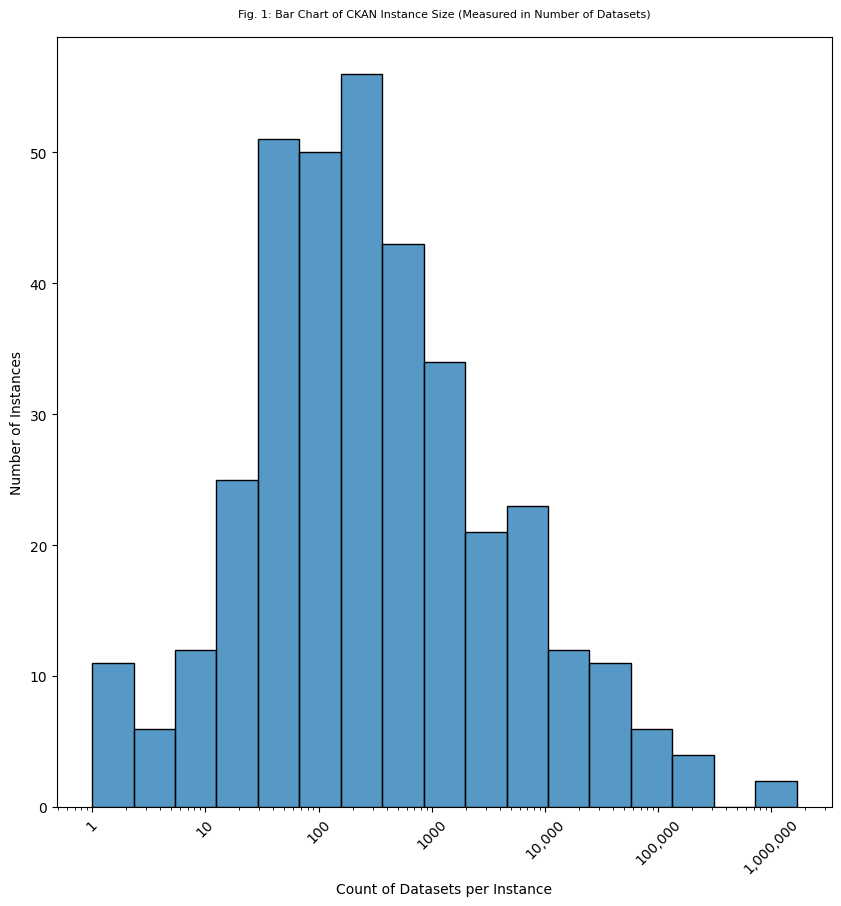

In [92]:
def ckan_packages_chart(all_urls_final):
    packages = []
    for row in all_urls_final:
        try:
            package_count = row['package_list_count']
            if package_count != '':
                packages.append(int(package_count))
        except KeyError:
            pass

    sorted_sizes_adjusted = sorted([1 if s == 0 else s for s in packages], reverse=True)
    sizes_plus_ranks = {'rank': range(len(sorted_sizes_adjusted)), 'package_count': sorted_sizes_adjusted}

    warnings.filterwarnings("ignore", category=UserWarning)
    fig, ax = plt.subplots(figsize=(10,10))
    seaborn.histplot(data=sizes_plus_ranks, x='package_count', log_scale=(True, False))
    ax.set_xlabel("Count of Datasets per Instance")
    ax.set_ylabel("Number of Instances")
    plt.xticks(rotation=45)
    ax.set_xticklabels(['0', '.1', '1', '10', '100', '1000', '10,000', '100,000', '1,000,000'])
    plt.title("Fig. 1: Bar Chart of CKAN Instance Size (Measured in Number of Datasets)\n", size=8)
    plt.savefig("packages_chart.png")
    plt.show()

ckan_packages_chart(prepped)

In [93]:
def time_calcs(all_urls_final):
    year_list = []
    time_dict = {}
    today = datetime.today()
    url_list = []
    overall_count = 0
    for y in range(2007, 2024):
        annual_count = 0
        age = 0
        timedeltas = []
        age_pct = []
        for item in all_urls_final:
            try:
                if 'oldest_metadata_created_date' in item.keys():
                    if 'most_recent_update_date' in item.keys():
                        if type(item['oldest_metadata_created_date']) == datetime:
                            if type(item['most_recent_update_date']) == datetime:
                                year_list.append((item['oldest_metadata_created_date'], item['most_recent_update_date']))
                                if int(item['oldest_metadata_created_date'].strftime('%Y')) == y:
                                    annual_count+=1
                                    overall_count+=1
                                    oldest = item['oldest_metadata_created_date']
                                    most_recent = item['most_recent_update_date']
                                    timedeltas.append(int((most_recent-oldest).days))
                                    age_pct.append(int((most_recent-oldest).days) / int((today - oldest).days))
                                    url_list.append(item['source_url'])

            except Exception as e:
                print(item['oldest_metadata_created_date'], item['source_url'], e)
        if len(timedeltas)>0:
            avg_age = round((sum(timedeltas)/len(timedeltas))/365, 2)
            median_age = round(statistics.median(timedeltas)/365, 2)
        else:
            avg_age = 0
            median_age = 0
        if len(age_pct)>0:
            age_pct_amt = round(((sum(age_pct))/(len(age_pct))), 2)
        else:
            age_pct_amt = 0
        time_dict[y] = {"year":y, "count": annual_count, "avg_age":avg_age, "median":median_age, "average_lifespan":age_pct_amt}
    return(time_dict, overall_count)

time_dict, overall_count = time_calcs(prepped)

2023-07-05 23:03:20.652195 http://b2find.eudat.eu division by zero
2023-07-06 00:50:05.283110 http://dados.ana.gov.br division by zero


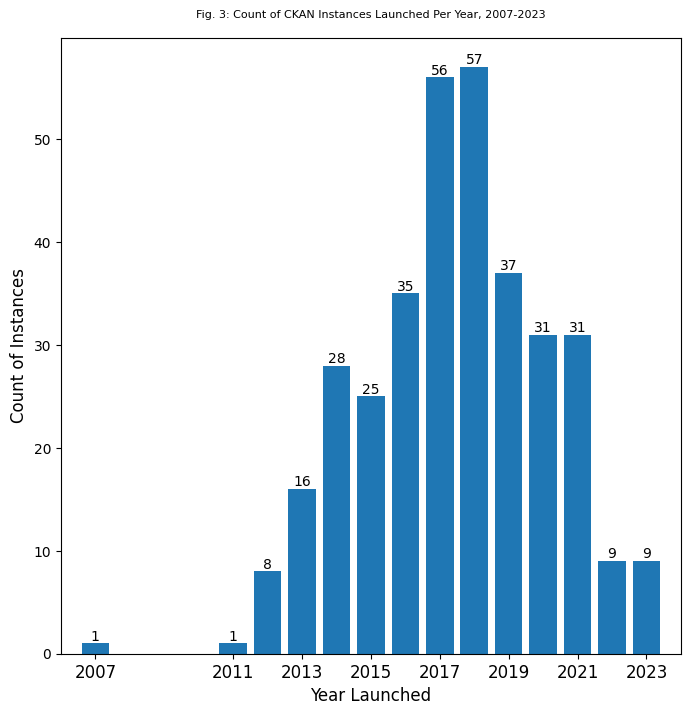

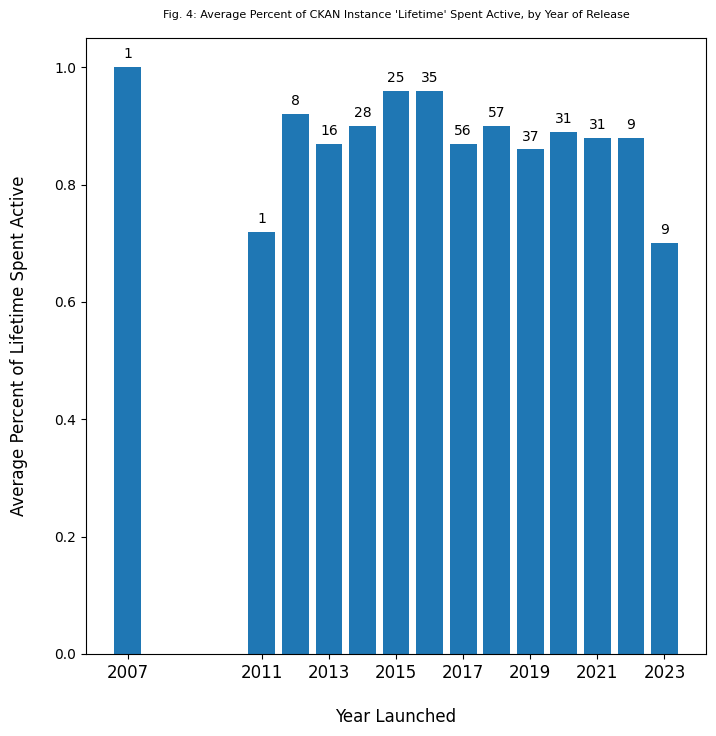

In [97]:
def graphing(time_dict):
    time_dict = sorted(time_dict.items())
    list_of_time_dicts = [item[1] for item in time_dict]
    count_list = []
    age_list = []
    lifespan_list = []
    for item in list_of_time_dicts:
        if item["count"] > 0:
            count_list.append((item["year"], item["count"]))
            age_list.append((item["year"], item["avg_age"]))
            lifespan_list.append((item["year"], item["average_lifespan"]))

    x_axis_count, y_axis_count = zip(*count_list)
    x_axis_age, y_axis_age = zip(*age_list)
    x_axis_life, y_axis_life = zip(*lifespan_list)

    fig, ax = plt.subplots(figsize=(8, 8))
    bars = ax.bar(x_axis_count, y_axis_count)
    ax.set_xlabel("Year Launched", fontsize=12)
    ax.set_ylabel("Count of Instances", fontsize=12)
    x_list = [2007, 2011, 2013, 2015, 2017, 2019, 2021, 2023]
    x = np.array(x_list)
    plt.xticks(x, fontsize=12)
    ax.bar_label(bars)
    ax.set_xlim(2006, 2024)
    plt.title("Fig. 3: Count of CKAN Instances Launched Per Year, 2007-2023\n", size=8)
    plt.savefig("ckan_per_year.png")

    fig, ax = plt.subplots(figsize=(8, 8))
    bars = ax.bar(x_axis_life, y_axis_life, color="#1f77b4")
    ax.set_xlabel("\nYear Launched", fontsize=12)
    ax.set_ylabel("Average Percent of Lifetime Spent Active\n", fontsize=12)
    ax.tick_params(axis='y', labelsize=10)
    x_list = [2007, 2011, 2013, 2015, 2017, 2019, 2021, 2023]
    x = np.array(x_list)
    labels = [str(item) for item in x_axis_life]
    plt.xticks(x, fontsize=12)
    rects = ax.patches
    for rect, label in zip(rects, y_axis_count):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label, ha="center", va="bottom")
    fig.savefig("test.png", bbox_inches="tight")
    plt.title("Fig. 4: Average Percent of CKAN Instance 'Lifetime' Spent Active, by Year of Release\n", size=8)
    plt.savefig("ckan_lifetime.png")
    
graphing(time_dict)

In [100]:
def ckan_version(all_urls_final):
    version_list = []
    for item in all_urls_final:
        try:
            version_list.append(item['version'].split('.')[:2])
        except KeyError:
            pass

    for item in version_list:
        if "b" in item[1]:
            item[1] = item[1].replace("b", "")

    version_3_list = [item for item in version_list if item[0] == '3']
    for item in version_3_list:
        version_list.remove(item)

    version_3_list_final = [item for item in version_3_list if item[1] != "0#datapress"]
    a, b = zip(*version_list)
    version_count = Counter(b)
    version_dict = {f'2.{item}': version_count[item] for item in version_count}

    if len(version_3_list_final) > 0:
        c, d = zip(*version_3_list_final)
        version_3_count = Counter(d)
        version_3_dict = {f'3.{item}': version_3_count[item] for item in version_3_count}
        for item in version_3_dict:
            version_dict[item] = version_3_dict[item]
    x_data = list(sorted(version_dict))
    if '2.10' in x_data:
        if x_data[-1] == '2.10':
            pass
        elif x_data[2] == '2.10':
            x_data.pop(2)
            if x_data[-1] == '2.9':
                x_data.append('2.10')
            else:
                for x in range(len(x_data)):
                    if x_data[x][0] == '3':
                        insert_point = x
                        break
                x_data.insert(insert_point, '2.10')
    y_data = [version_dict[item] for item in x_data]
    return(x_data, y_data)

x_data, y_data = ckan_version(prepped)

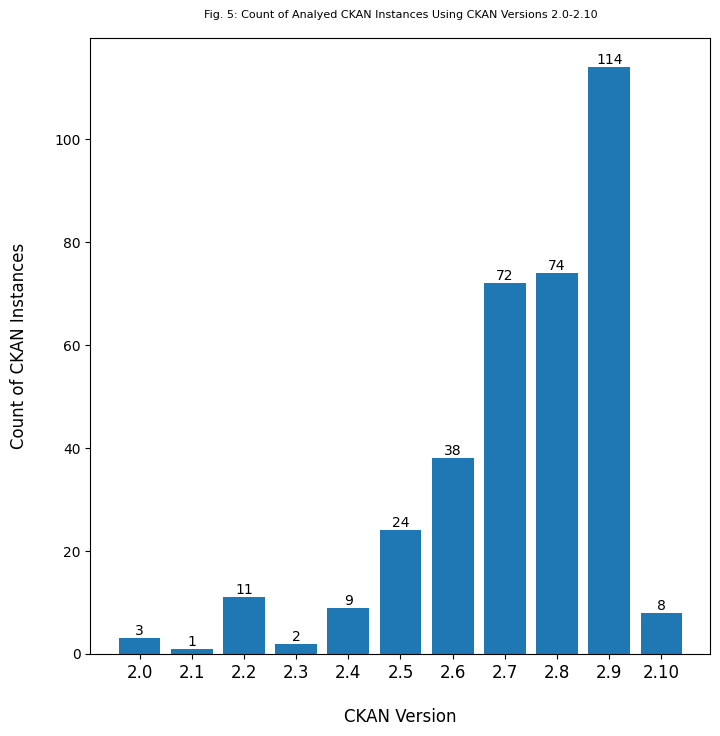

In [101]:
def ckan_version_chart(x_data, y_data):
    fig, ax = plt.subplots(figsize=(8,8))
    bars = ax.bar(x_data, y_data, color="#1f77b4")
    ax.set_xlabel("\nCKAN Version", fontsize=12)
    ax.set_ylabel("Count of CKAN Instances\n", fontsize=12)
    ax.tick_params(axis='y', labelsize=10)
    labels = [str(item) for item in x_data]
    plt.xticks(labels, fontsize=12)
    rects = ax.patches
    for rect, label in zip(rects, y_data):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+ 0.01, label, ha="center", va="bottom")
    fig.savefig("test.png", bbox_inches="tight")
    plt.title("Fig. 5: Count of Analyed CKAN Instances Using CKAN Versions 2.0-2.10\n", size=8)
    plt.savefig("version_count.png")
    plt.show()
    
ckan_version_chart(x_data, y_data)